In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+47.g7f2fb8c32.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.02 GB available memory.


# About this Notebook

We will get the free boundary equilibrium solution to the HBT base coils.

!!! What should be the profiles? Should we optimize for them? Or are there some good starting points?

In [43]:
field = load("hbt_default_coils.h5")
eq0 = load("desc-eq-HBT-limited.h5")
eq0.solve(verbose=3, maxiter=100, ftol=1e-4);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 29.6 ms
Timer: Objective build = 39.4 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 99.5 ms
Timer: LinearConstraintProjection build = 126 ms
Number of parameters: 384
Number of objectives: 1122
Timer: Initializing the optimization = 281 ms

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust R

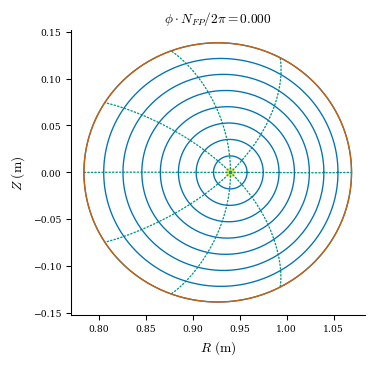

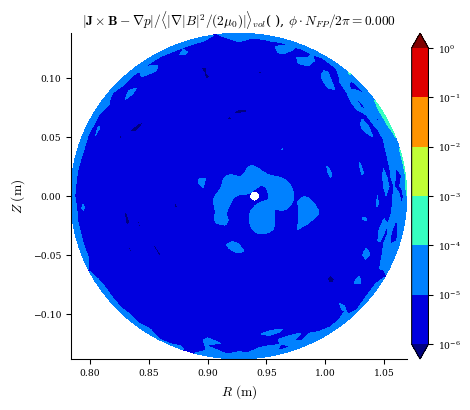

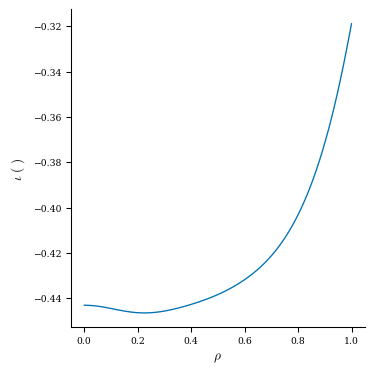

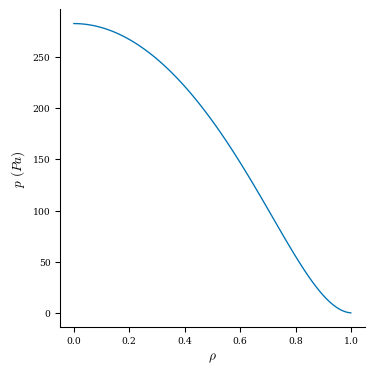

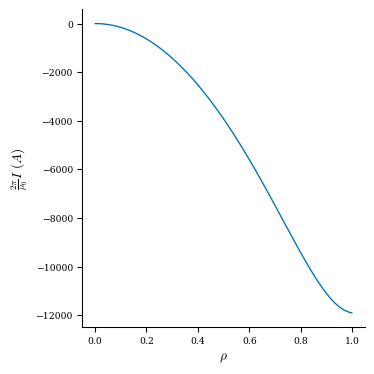

In [37]:
plot_surfaces(eq0)
plot_section(eq0, "|F|_normalized", log=True);
plot_1d(eq0, "iota")
plot_1d(eq0, "pressure")
plot_1d(eq0, "current");

In [44]:
for i in range(len(field.coils)):
    for j in range(len(field.coils[i].coils)):
        field.coils[i].coils[j].current *= -1
        print(f"Switching current direction of {field.coils[i].coils[j].name}")

Switching current direction of TF coil
Switching current direction of Outer VF coil
Switching current direction of Outer VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner VF coil
Switching current direction of Inner OH coil
Switching current direction of Inner OH coil
Switching current direction of Inner OH coil
Switching current direction of Inner OH coil
Switching current direction of Inner OH coil
Switching current direction of Inner OH coil
Switching current direction of Inner OH coil
Switching curren

In [45]:
# scale the TF coil current
field.coils[0].coils[0].current *= 1

In [46]:
eq = eq0.copy()
eq.iota = eq.get_profile("iota")
coil_grid = LinearGrid(N=50)
objective = ObjectiveFunction(
    BoundaryError(eq=eq, field=field, field_fixed=True, field_grid=coil_grid)
)
constraints = (
    ForceBalance(eq=eq, grid=QuadratureGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)),
    FixPressure(eq=eq),
    FixPsi(eq=eq),
)
if eq.current is not None:
    constraints += (FixCurrent(eq),)
else:
    constraints += (FixIota(eq),)

/CODES/DESC/desc/utils.py:572: UserWarning: Setting rotational transform profile on an equilibrium with fixed toroidal current, removing existing toroidal current profile.
  warnings.warn(msg, err)


In [47]:
k = 3
R_modes = eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :]
Z_modes = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :]
bdry_constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),
)
eq, out = eq.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    x_scale="ess",
    verbose=3,
    maxiter=100,
    ftol=1e-3,
)

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 14.9 ms
Timer: Objective build = 53.4 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 38.9 ms
Timer: Objective build = 55.0 ms
Timer: Objective build = 1.15 ms
Timer: Eq Update LinearConstraintProjection build = 113 ms
Timer: Proximal projection build = 3.56 sec
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed iota
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 152 ms
Timer: LinearConstraintProjection build = 158 ms
Number of parameters: 14
Number of objectives: 130
Timer: Initializing the optimization = 4.01 sec

Starting optimization
Using method: proximal-lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method 

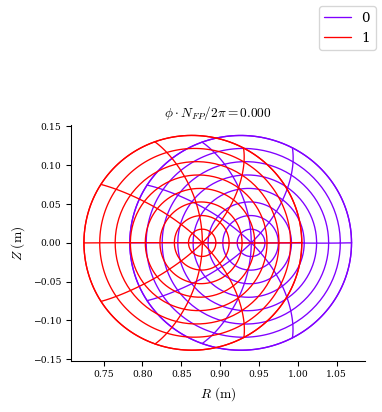

In [48]:
# this is not what I expect right now!
plot_comparison([eq0, eq]);

In [ ]:
plot_section(eq, "|F|_normalized", log=True)
plot_section(eq, "|B|");

In [ ]:
fig = plot_coils(field)
plot_3d(eq, "|B|", fig=fig);